In [35]:
from utils import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


users_df, billing_df, sessions_df, events_df = load_data()



                                    user_id  has_upgraded
0      f94d1824-8742-4000-8b6d-39d70958490b             0
1      238bf0af-1f71-45e4-a47d-dcb5db33f71b             0
2      ccf8fc06-3c86-433c-8867-9cba0fda337b             0
3      3e39c0ea-ebbf-43bc-abd5-ab92eff6fa10             1
4      9304dcbe-682d-41fa-8bfd-861559f9f58b             0
...                                     ...           ...
99995  e7e9d70c-478e-4d57-982a-53c98a175328             1
99996  1b74fc26-9c01-4aeb-95db-587abfda6e73             1
99997  c209e590-7bcc-4aff-b3cd-c9c498491c22             0
99998  06bde50d-e9b3-4db9-8353-cf0279d0060b             1
99999  2bebcb3d-bead-492a-97e3-1346173ee638             0

[100000 rows x 2 columns]


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_93506/1453306300.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


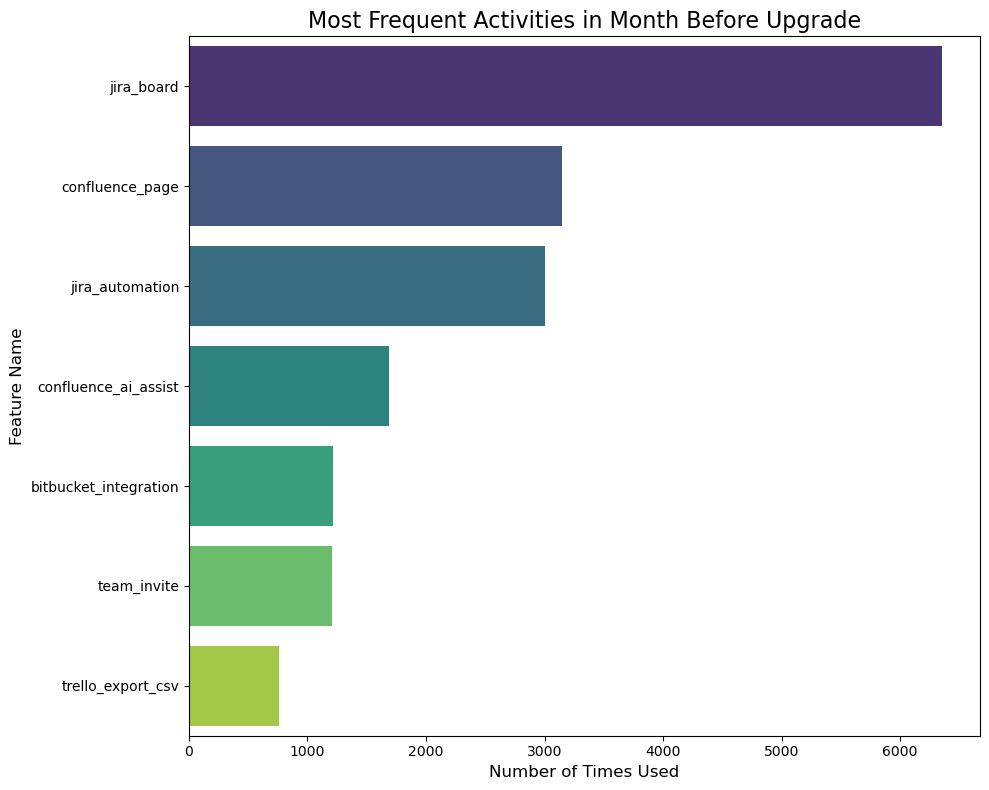

In [34]:
# cleaning: month = datetime, upgraded defined as increase in mrr for 2 months

billing_df['month'] = pd.to_datetime(billing_df['month'])
billing_df = billing_df.sort_values(by=['user_id', 'month'])
billing_df['mrr_diff'] = billing_df.groupby('user_id')['mrr'].diff()

upgraded_users = billing_df[billing_df['mrr_diff'] > 0]['user_id'].unique()
upgrade_target_df = pd.DataFrame({'user_id': users_df['user_id'].unique()})
upgrade_target_df['has_upgraded'] = upgrade_target_df['user_id'].isin(upgraded_users).astype(int)

print(upgrade_target_df)

# check pre-upgrade month activity, find small idx, then merge with event
events_df['ts'] = pd.to_datetime(events_df['ts'])

upgrades_df = billing_df[billing_df['mrr_diff'] > 0].copy()
first_upgrade_indices = upgrades_df.groupby('user_id')['month'].idxmin()
first_upgrade_moments = upgrades_df.loc[first_upgrade_indices][['user_id', 'month']]
first_upgrade_moments.rename(columns={'month': 'upgrade_month'}, inplace=True)
first_upgrade_moments['pre_upgrade_month'] = first_upgrade_moments['upgrade_month'] - pd.DateOffset(months=1)

pre_upgrade_events = pd.merge(events_df, first_upgrade_moments,on='user_id')
pre_upgrade_events = pre_upgrade_events[pre_upgrade_events['ts'].dt.to_period('M') == pre_upgrade_events['pre_upgrade_month'].dt.to_period('M')]

if not pre_upgrade_events.empty:

    top_features = pre_upgrade_events['feature_name'].value_counts()

    plt.figure(figsize=(10, 8))
    sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
    plt.title('Most Frequent Activities in Month Before Upgrade', fontsize=16)
    plt.xlabel('Number of Times Used', fontsize=12)
    plt.ylabel('Feature Name', fontsize=12)
    plt.tight_layout()

else:
    print("\nCould not find sufficient event data in the pre-upgrade months to analyze.")


Aggregating feature usage and total event counts from events data...


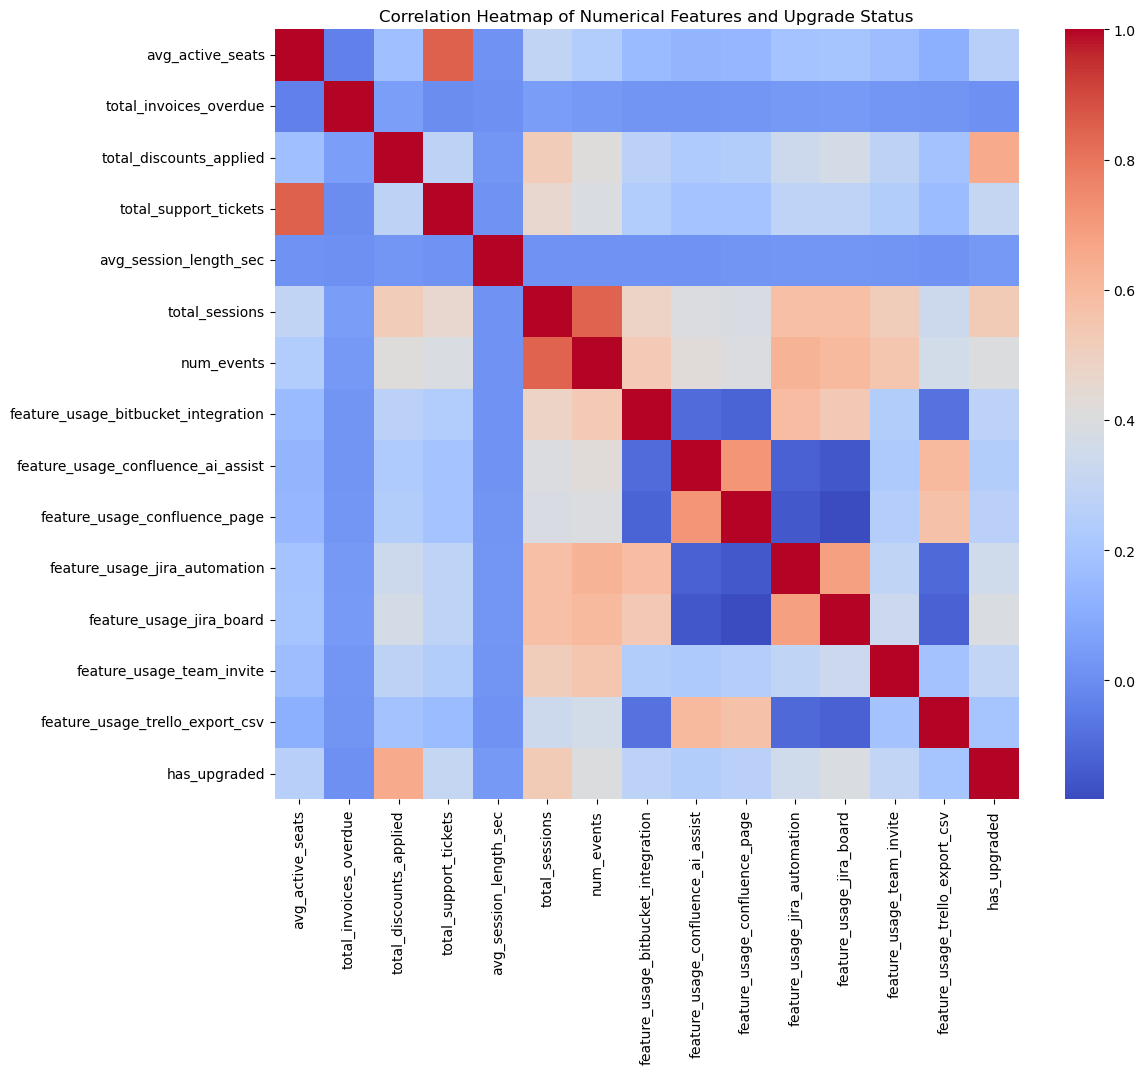

                 precision    recall  f1-score   support

Did Not Upgrade       0.93      0.95      0.94     11424
       Upgraded       0.93      0.90      0.92      8576

       accuracy                           0.93     20000
      macro avg       0.93      0.93      0.93     20000
   weighted avg       0.93      0.93      0.93     20000



Text(0.5, 1.0, 'Upgrade Prediction Confusion Matrix (MRR-Based)')

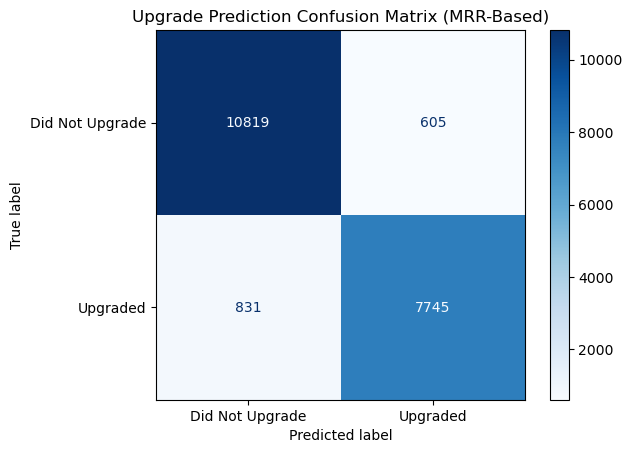

In [ ]:
# same aggregation as other files
billing_agg = bill_agregate(billing_df)

# b) Session data aggregation
sessions_df['session_start'] = pd.to_datetime(sessions_df['session_start'])
sessions_agg = session_aggregate(sessions_df)

# c) Events data aggregation (add feature usage counts)
print("Aggregating feature usage and total event counts from events data...")
feature_counts = events_df.groupby(['user_id', 'feature_name']).size().unstack(fill_value=0)
feature_counts.columns = [f'feature_usage_{col.replace(" ", "_")}' for col in feature_counts.columns]
feature_counts.reset_index(inplace=True)

events_agg = events_df.groupby('user_id').agg(
    num_events=('event_id', 'count')
).reset_index()


# Merge
df = users_df.drop_duplicates(subset='user_id')
df = pd.merge(df, billing_agg, on='user_id', how='left')
df = pd.merge(df, sessions_agg, on='user_id', how='left')
df = pd.merge(df, events_agg, on='user_id', how='left')
df = pd.merge(df, feature_counts, on='user_id', how='left')
df = pd.merge(df, upgrade_target_df, on='user_id', how='left')


TARGET = 'has_upgraded'

features = [
    'company_size', 'industry', 'acquisition_channel', 'is_enterprise',
    'avg_active_seats', 'total_invoices_overdue', 'total_discounts_applied',
    'total_support_tickets', 'avg_session_length_sec', 'total_sessions', 'num_events'
]
feature_usage_cols = [col for col in df.columns if col.startswith('feature_usage_')]
features.extend(feature_usage_cols)

model_df = df[features + [TARGET]].copy()

# Missing = 0 for categorical; median for numerical
for col in feature_usage_cols:
    if col in model_df.columns:
        model_df[col] = model_df[col].fillna(0)

for col in model_df.select_dtypes(include=['float64', 'int64']).columns:
    model_df[col] = model_df[col].fillna(model_df[col].median())

for col in model_df.select_dtypes(include=['object']).columns:
    model_df[col] = model_df[col].fillna(model_df[col].mode()[0])


numerical_features = model_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = model_df[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm') 
plt.title('Correlation Heatmap of Numerical Features and Upgrade Status')
plt.show()

# One-hot encode categorical variables
categorical_cols = model_df.select_dtypes(include=['object']).columns
model_df = pd.get_dummies(model_df, columns=categorical_cols, drop_first=True)

# Train
X = model_df.drop(TARGET, axis=1)
y = model_df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Did Not Upgrade', 'Upgraded']))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did Not Upgrade', 'Upgraded'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Upgrade Prediction Confusion Matrix (MRR-Based)')

Accuracy looks great. Discount, usage and jira board seems like the reason for upgrade. 

has_upgraded
0    57120
1    42880
Name: count, dtype: int64
Top 5 most important features for predicting upgrades:
                   feature  importance
3  total_discounts_applied    0.334209
6           total_sessions    0.168379
1         avg_active_seats    0.120991
7               num_events    0.068043
4    total_support_tickets    0.060923


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_93506/686747091.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_5_features, palette='viridis')


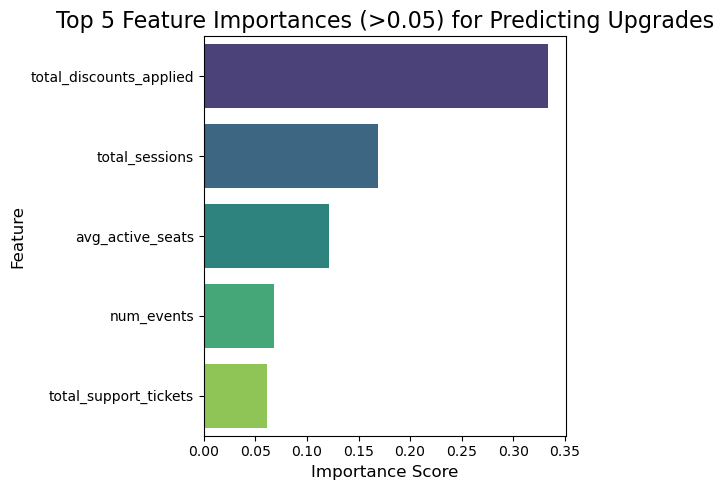

In [14]:
print(model_df[TARGET].value_counts())

importances = model.feature_importances_
feature_names = X_train.columns

# Sort features by importance then plot
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
top_5_features = feature_importance_df.head(5)

print("Top 5 most important features for predicting upgrades:")
print(top_5_features)

# Create the visualization
plt.figure(figsize=(6, 5))
sns.barplot(x='importance', y='feature', data=top_5_features, palette='viridis')
plt.title('Top 5 Feature Importances (>0.05) for Predicting Upgrades', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()

Validating discount > usage >> support

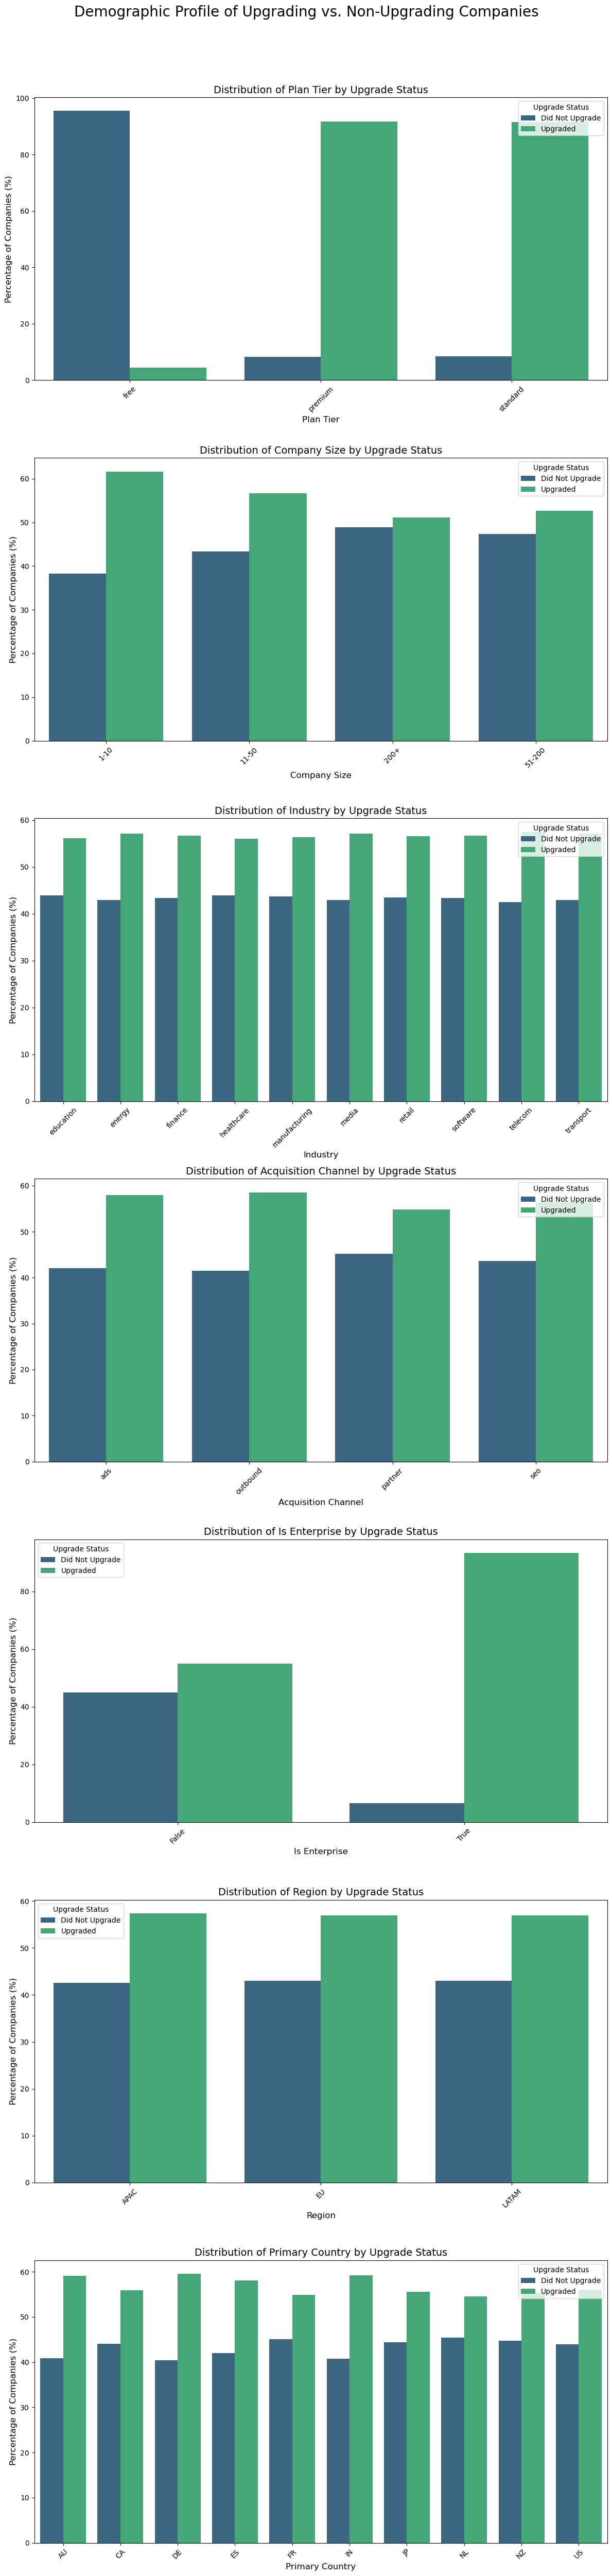

In [ ]:
# Identifying users who have upgraded

# A user might have sessions from multiple countries. We'll find the most frequent one.
user_country = sessions_df.groupby('user_id')['country'].agg(lambda x: x.mode()[0] if not x.empty else None).reset_index()
user_country.rename(columns={'country': 'primary_country'}, inplace=True)

analysis_df = pd.merge(users_df, user_country, on='user_id', how='left')

# Drop users with no session data
analysis_df.dropna(subset=['primary_country'], inplace=True)

demographic_features = [
    'plan_tier', 'company_size', 'industry', 'acquisition_channel',
    'is_enterprise', 'region', 'primary_country'
]

# Only look at the top 10 most common countries
top_10_countries = analysis_df['primary_country'].value_counts().nlargest(10).index
analysis_df_top_countries = analysis_df[analysis_df['primary_country'].isin(top_10_countries)]


fig, axes = plt.subplots(len(demographic_features), 1, figsize=(12, 7 * len(demographic_features)))
fig.suptitle('Demographic Profile of Upgrading vs. Non-Upgrading Companies', fontsize=20, y=1.02)

for i, feature in enumerate(demographic_features):
    ax = axes[i]
    plot_data = analysis_df_top_countries if feature == 'primary_country' else analysis_df

    df_plot = plot_data.groupby(feature)['has_upgraded'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

    sns.barplot(x=feature, y='percent', hue='has_upgraded', data=df_plot, ax=ax, palette='viridis')

    ax.set_title(f'Distribution of {feature.replace("_", " ").title()} by Upgrade Status', fontsize=14)
    ax.set_ylabel('Percentage of Companies (%)', fontsize=12)
    ax.set_xlabel(feature.replace("_", " ").title(), fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['Did Not Upgrade', 'Upgraded'], title='Upgrade Status')


plt.tight_layout(rect=[0, 0, 1, 1]) 

user_id                               upgraded_from_free  upgraded_from_standard  has_upgraded
0000093e-7258-43c0-b212-ea7212795ddf  False               False                   False           1
aada0e17-1de5-46ca-a541-ff9bf97f58a8  False               False                   False           1
aaeac088-8e82-4e18-959a-193c495464c9  False               False                   False           1
aaea3c6b-b509-4b73-8bb4-586258ea0de7  False               False                   False           1
aae9ff9e-9280-41d8-bb4a-84390d36ebeb  False               False                   False           1
                                                                                                 ..
556f1b9c-618a-41f0-a898-4d94fa635d78  False               False                   False           1
556e758d-f700-4f10-9a01-462b7eaf653e  False               False                   False           1
556d4ff1-5238-41dc-8471-0e346f570ca8  False               False                   False           1
556d3

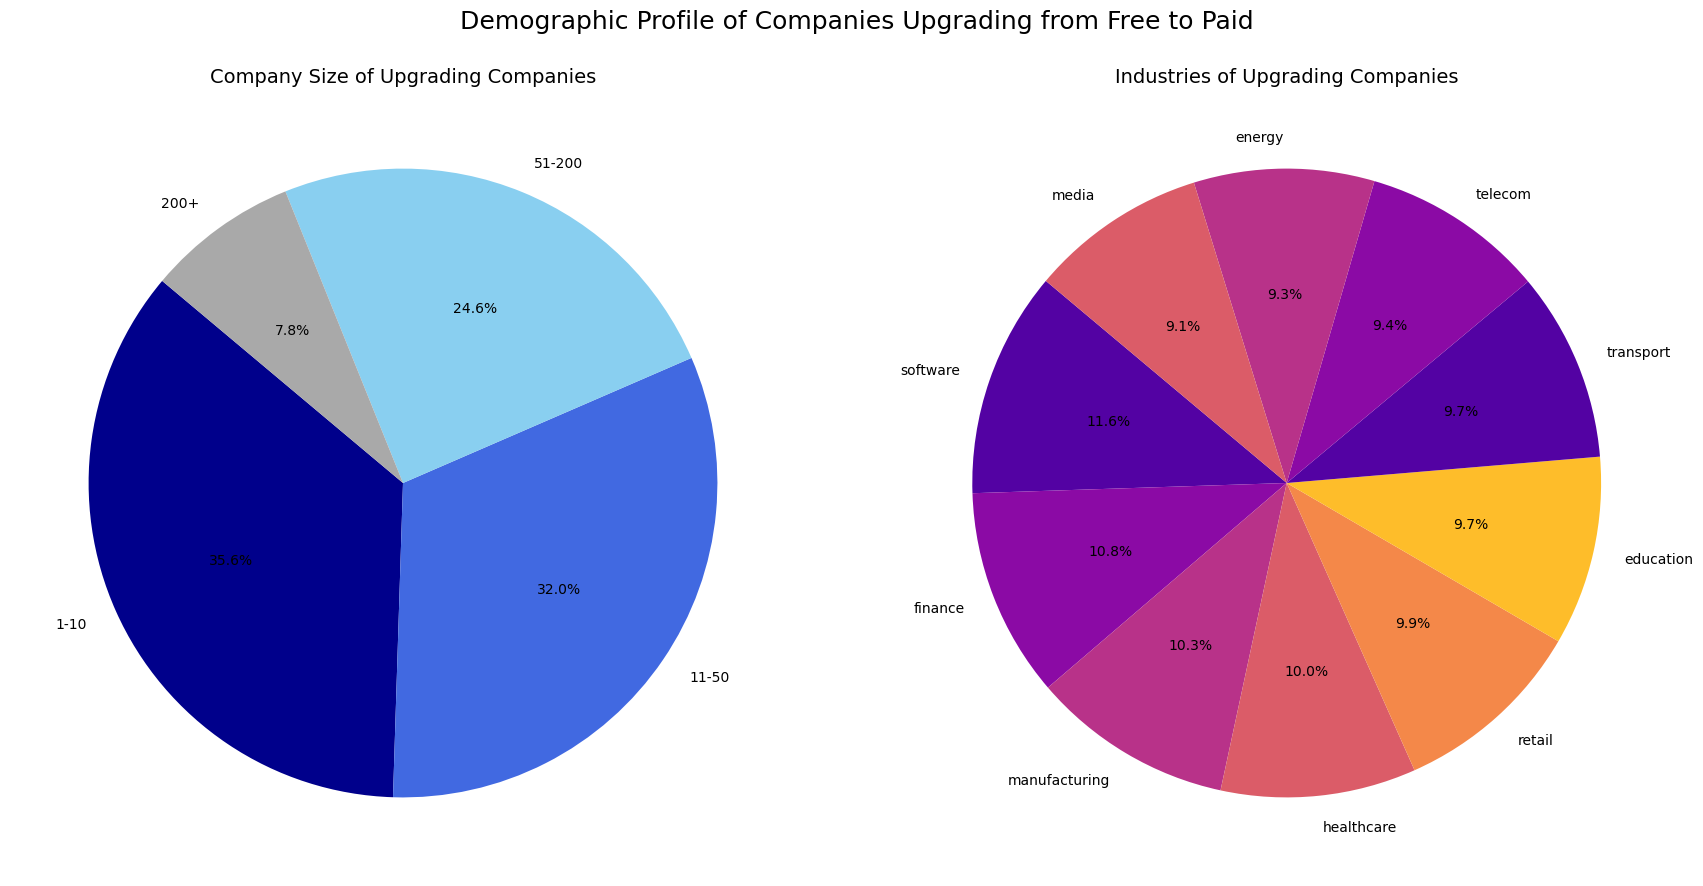

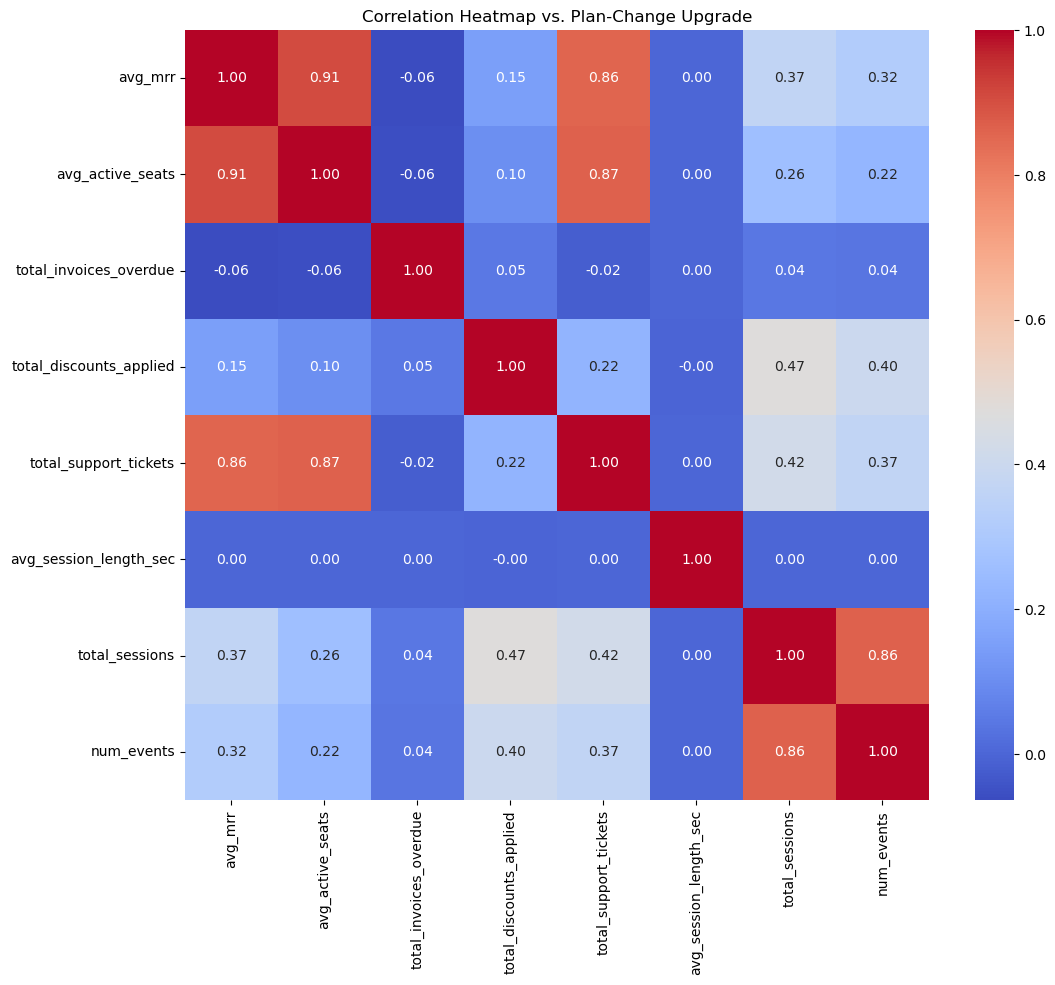

                 precision    recall  f1-score   support

Did Not Upgrade       0.97      1.00      0.99     11119
       Upgraded       0.97      0.11      0.20       344

       accuracy                           0.97     11463
      macro avg       0.97      0.56      0.59     11463
   weighted avg       0.97      0.97      0.96     11463



Text(0.5, 1.0, 'Plan-Change Upgrade Prediction Confusion Matrix')

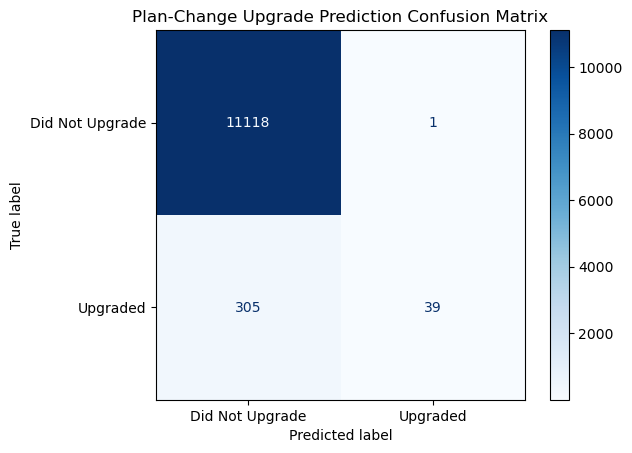

In [29]:
billing_df = pd.read_csv('billing.csv')
billing_df['month'] = pd.to_datetime(billing_df['month'])
billing_df = billing_df.sort_values(by=['user_id', 'month'])

def detect_plan_upgrade(plans):
    """Checks for specific plan transitions in a user's history."""
    plans_tuple = tuple(plans)
    upgraded_from_free = ('free', 'standard') in zip(plans_tuple, plans_tuple[1:]) or \
                         ('free', 'premium') in zip(plans_tuple, plans_tuple[1:])
    upgraded_from_standard = ('standard', 'premium') in zip(plans_tuple, plans_tuple[1:])
    return pd.Series([upgraded_from_free, upgraded_from_standard])

upgrade_flags = billing_df.groupby('user_id')['plan_tier'].apply(detect_plan_upgrade).unstack()
upgrade_flags.columns = ['upgraded_from_free', 'upgraded_from_standard']
upgrade_flags = upgrade_flags.reset_index()

# The final target is if a user made ANY of these upgrades
upgrade_flags['has_upgraded'] = upgrade_flags['upgraded_from_free'] | upgrade_flags['upgraded_from_standard']
upgrade_target_df = upgrade_flags[['user_id', 'has_upgraded']]

print(upgrade_flags.value_counts())

# "Free to Paid"
print("\n--- Analyzing 'Free to Paid' Upgraders ---")
free_to_paid_user_ids = upgrade_flags[upgrade_flags['upgraded_from_free']]['user_id']
free_to_paid_df = pd.merge(users_df, pd.DataFrame(free_to_paid_user_ids), on='user_id', how='inner')

# a) Calculate time to upgrade
if not free_to_paid_df.empty:
    first_paid_month = billing_df[billing_df['plan_tier'] != 'free'].groupby('user_id')['month'].min().reset_index()
    first_paid_month.rename(columns={'month': 'first_paid_month'}, inplace=True)
    time_to_upgrade_df = pd.merge(free_to_paid_df, first_paid_month, on='user_id')
    time_to_upgrade_df['signup_date'] = pd.to_datetime(time_to_upgrade_df['signup_date'])
    time_to_upgrade_df['months_to_upgrade'] = (time_to_upgrade_df['first_paid_month'].dt.to_period('M') - \
                                            time_to_upgrade_df['signup_date'].dt.to_period('M')).apply(lambda x: x.n)

    print(f"\nAverage time for a free user to upgrade: {time_to_upgrade_df['months_to_upgrade'].mean():.2f} months")

    
    # b) Visualize Demographics with Pie Charts
    fig, axes = plt.subplots(1, 2, figsize=(18, 9))
    fig.suptitle('Demographic Profile of Companies Upgrading from Free to Paid', fontsize=18)
    
    # Pie Chart 1: Company Size (with custom coloring)
    company_size_counts = free_to_paid_df['company_size'].value_counts()
    # Define custom colors: 3 shades of blue for the top 3, grey for the rest
    colors = ['#00008B', '#4169E1', '#89CFF0'] + ['#A9A9A9'] * (len(company_size_counts) - 3)
    axes[0].pie(company_size_counts, labels=company_size_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
    axes[0].set_title('Company Size of Upgrading Companies', fontsize=14)
    
    # Pie Chart 2: Industry
    industry_counts = free_to_paid_df['industry'].value_counts()
    axes[1].pie(industry_counts, labels=industry_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('plasma'))
    axes[1].set_title('Industries of Upgrading Companies', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
else:
    print("No users found who upgraded from a free plan.")


billing_agg = billing_df.groupby('user_id').agg(
    avg_mrr=('mrr', 'mean'),
    avg_active_seats=('active_seats', 'mean'),
    total_invoices_overdue=('invoices_overdue', 'sum'),
    total_discounts_applied=('discount_applied', 'sum'),
    total_support_tickets=('support_ticket_count', 'sum')
).reset_index()

sessions_agg = sessions_df.groupby('user_id').agg(
    total_sessions=('session_id', 'count'),
    avg_session_length_sec=('session_length_sec', 'mean')
).reset_index()

events_agg = events_df.groupby('user_id').agg(num_events=('event_id', 'count')).reset_index()

df = users_df.drop_duplicates(subset='user_id')
df = pd.merge(df, billing_agg, on='user_id', how='left')
df = pd.merge(df, sessions_agg, on='user_id', how='left')
df = pd.merge(df, events_agg, on='user_id', how='left')
df = pd.merge(df, upgrade_target_df, on='user_id', how='left')

TARGET = 'has_upgraded'
features = [
    'company_size', 'industry', 'acquisition_channel', 'is_enterprise',
    'avg_mrr', 'avg_active_seats', 'total_invoices_overdue', 'total_discounts_applied',
    'total_support_tickets', 'avg_session_length_sec', 'total_sessions', 'num_events'
]
model_df = df[features + [TARGET]].copy().dropna()

plt.figure(figsize=(12, 10))
numerical_features = model_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = model_df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap vs. Plan-Change Upgrade')
plt.show()

# Prepare data for model
model_df = pd.get_dummies(model_df, columns=model_df.select_dtypes(include=['object']).columns, drop_first=True)
X = model_df.drop(TARGET, axis=1)
y = model_df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train and Evaluate Model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Did Not Upgrade', 'Upgraded']))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did Not Upgrade', 'Upgraded'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Plan-Change Upgrade Prediction Confusion Matrix')

Top 20 most important features:
                         feature  importance
1                        avg_mrr    0.307222
2               avg_active_seats    0.131823
6         avg_session_length_sec    0.100381
7                 total_sessions    0.092530
5          total_support_tickets    0.072172
8                     num_events    0.063091
4        total_discounts_applied    0.060909
3         total_invoices_overdue    0.016137
23       acquisition_channel_seo    0.015200
9             company_size_11-50    0.014351
11           company_size_51-200    0.014016
22   acquisition_channel_partner    0.013324
21  acquisition_channel_outbound    0.010316
20            industry_transport    0.008940
12               industry_energy    0.008848
18             industry_software    0.008781
15        industry_manufacturing    0.008645
14           industry_healthcare    0.008490
16                industry_media    0.008404
19              industry_telecom    0.008396


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_93506/4130787461.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_20_features, palette='viridis')


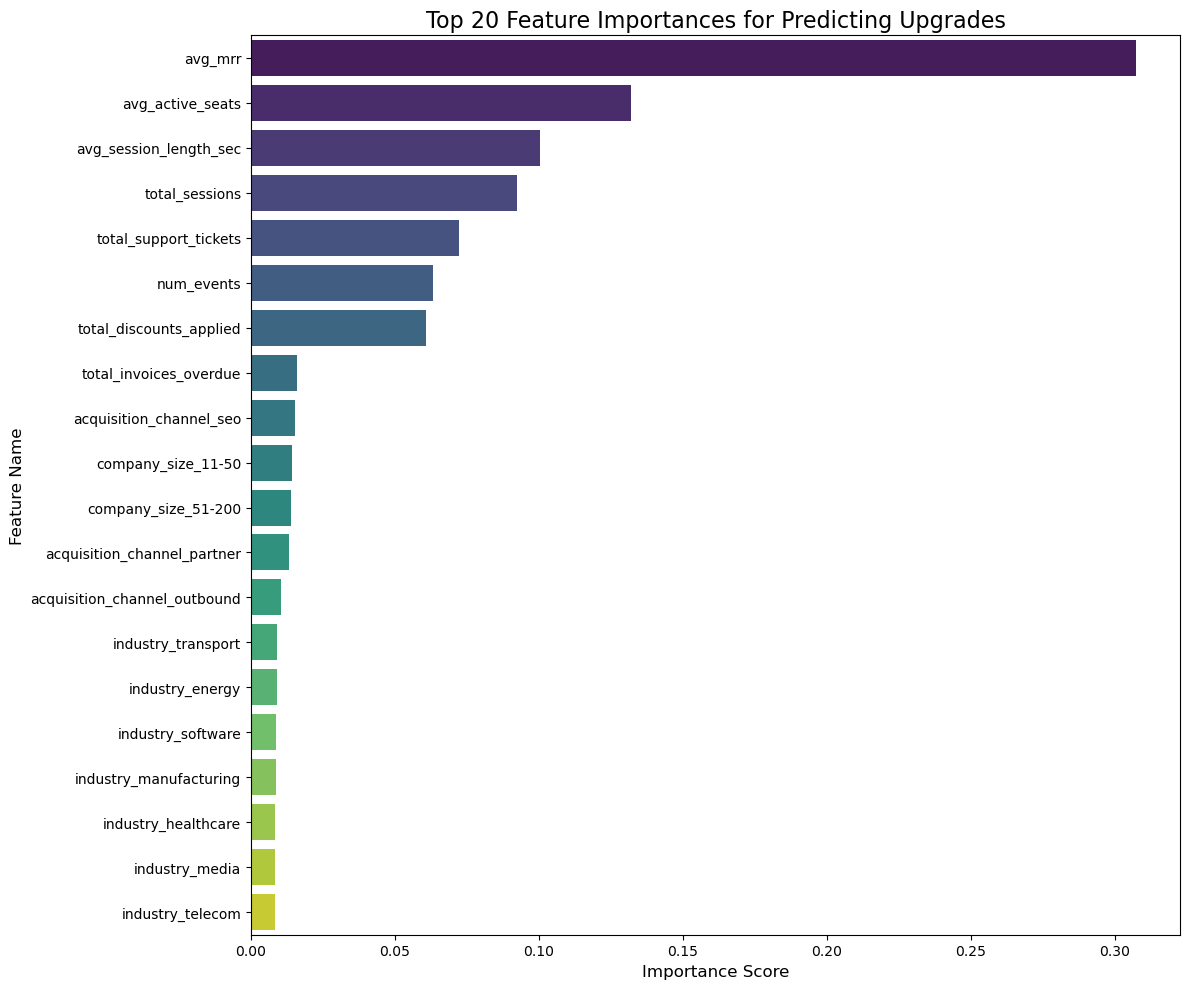

In [30]:
importances = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Get the top 20 most important features for readability
top_20_features = feature_importance_df.head(20)

print("Top 20 most important features:")
print(top_20_features)


# Visualize the top 20 feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=top_20_features, palette='viridis')
plt.title('Top 20 Feature Importances for Predicting Upgrades', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.tight_layout()

Analyzing feature usage by company size and plan...
Generating faceted visualization...


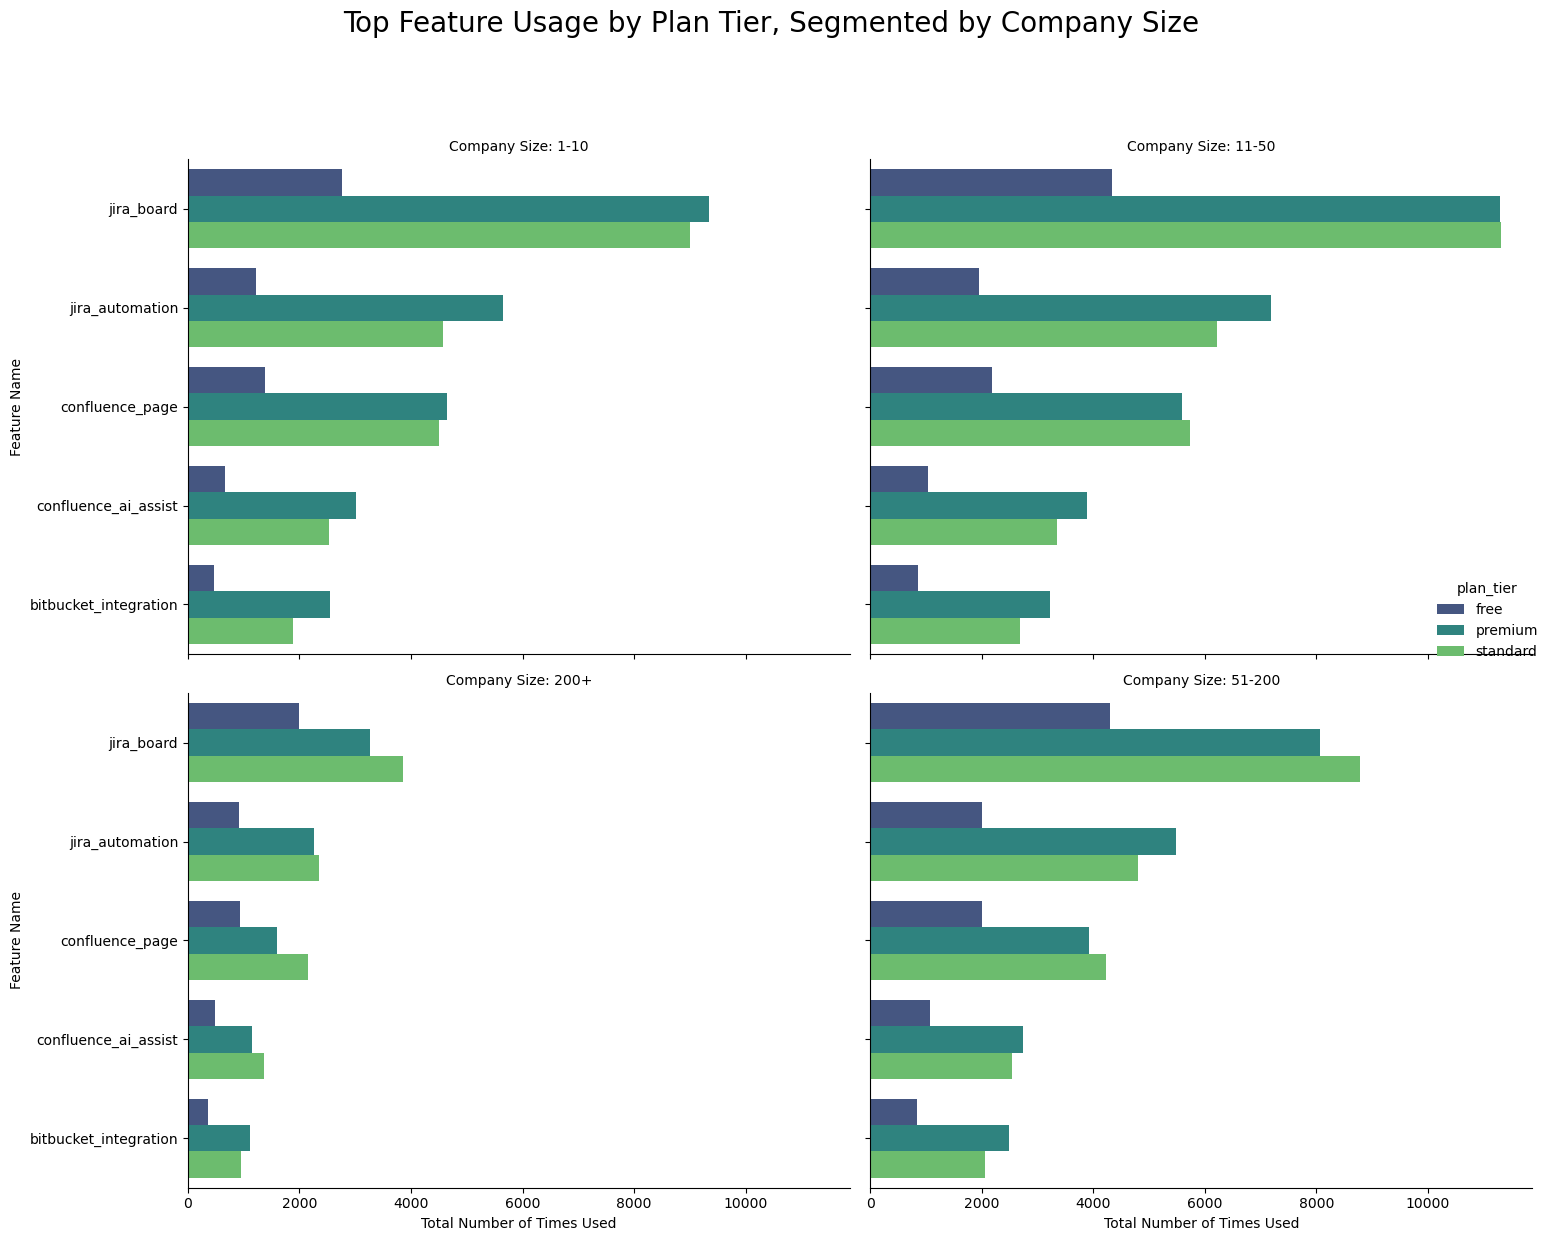

In [ ]:
company_info_df = users_df[['user_id', 'plan_tier', 'company_size']].drop_duplicates(subset='user_id')
merged_df = pd.merge(events_df, company_info_df, on='user_id', how='left')
merged_df.dropna(subset=['plan_tier', 'company_size'], inplace=True)


# --- 3. Analyze Feature Usage by Segment ---
print("Analyzing feature usage by company size and plan...")
# Calculate usage counts for every feature, grouped by both company size and plan tier
feature_counts = merged_df.groupby(['company_size', 'plan_tier', 'feature_name']).size().reset_index(name='usage_count')

# To keep the chart readable and comparable, let's find the top 5 features overall
overall_top_features = merged_df['feature_name'].value_counts().nlargest(5).index

# Filter our data to only include these top features
plot_data = feature_counts[feature_counts['feature_name'].isin(overall_top_features)]


# --- 4. Create the Combined, Faceted Visualization ---
print("Generating faceted visualization...")
# Use seaborn's catplot to create a grid of plots (facets) for each company size
g = sns.catplot(
    data=plot_data,
    x='usage_count',
    y='feature_name',
    hue='plan_tier',
    col='company_size',  # This creates a separate column of charts for each company size
    kind='bar',
    palette='viridis',
    height=6,
    aspect=1.2,
    col_wrap=2,          # Wrap the charts onto the next row after 2 plots
    order=overall_top_features  # Ensures a consistent y-axis order across all charts
)

g.fig.suptitle('Top Feature Usage by Plan Tier, Segmented by Company Size', fontsize=20, y=1.03)
g.set_axis_labels('Total Number of Times Used', 'Feature Name')
g.set_titles("Company Size: {col_name}")
g.tight_layout(rect=[0, 0, 1, 0.97])

Analyzing feature usage by industry and plan...
Generating faceted visualization...


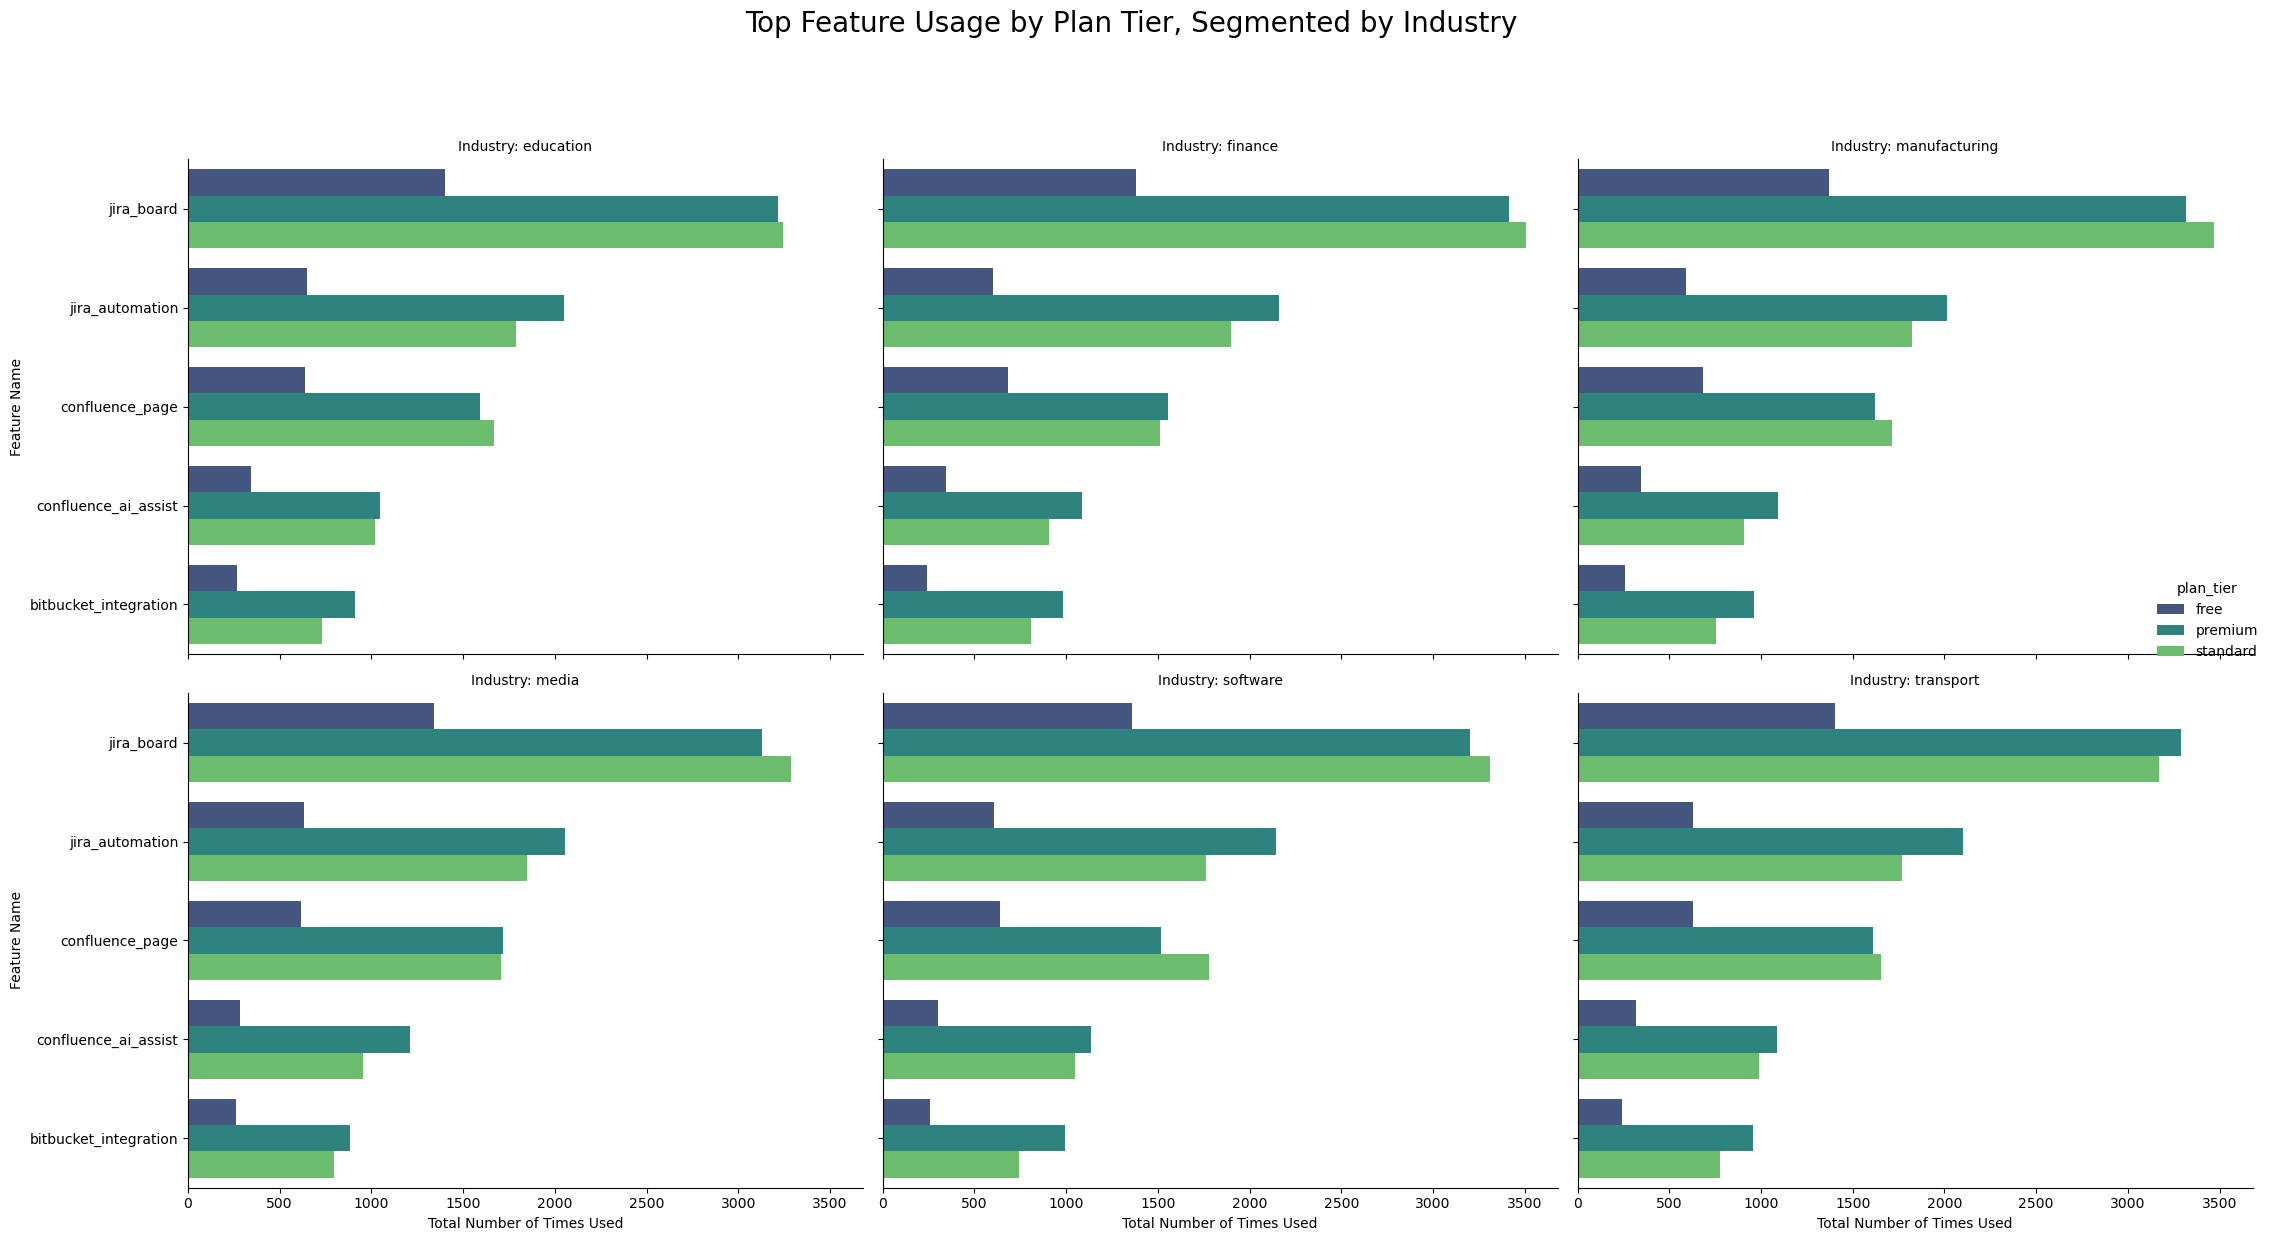

In [32]:
company_info_df = users_df[['user_id', 'plan_tier', 'industry']].drop_duplicates(subset='user_id')
merged_df = pd.merge(events_df, company_info_df, on='user_id', how='left')
merged_df.dropna(subset=['plan_tier', 'industry'], inplace=True)


# --- 3. Analyze Feature Usage by Segment ---
print("Analyzing feature usage by industry and plan...")
# Calculate usage counts for every feature, grouped by both industry and plan tier
feature_counts = merged_df.groupby(['industry', 'plan_tier', 'feature_name']).size().reset_index(name='usage_count')

# To keep the chart readable, let's find the top 5 features overall
overall_top_features = merged_df['feature_name'].value_counts().nlargest(5).index
# And find the top 6 most common industries
top_industries = merged_df['industry'].value_counts().nlargest(6).index

# Filter our data to only include these top features and top industries
plot_data = feature_counts[
    feature_counts['feature_name'].isin(overall_top_features) &
    feature_counts['industry'].isin(top_industries)
]


# --- 4. Create the Combined, Faceted Visualization ---
print("Generating faceted visualization...")
# Use seaborn's catplot to create a grid of plots (facets) for each industry
g = sns.catplot(
    data=plot_data,
    x='usage_count',
    y='feature_name',
    hue='plan_tier',
    col='industry',  # This creates a separate column of charts for each industry
    kind='bar',
    palette='viridis',
    height=6,
    aspect=1.2,
    col_wrap=3,          # Wrap the charts onto the next row after 3 plots
    order=overall_top_features  # Ensures a consistent y-axis order across all charts
)

g.fig.suptitle('Top Feature Usage by Plan Tier, Segmented by Industry', fontsize=20, y=1.03)
g.set_axis_labels('Total Number of Times Used', 'Feature Name')
g.set_titles("Industry: {col_name}")
g.tight_layout(rect=[0, 0, 1, 0.97])